In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.integrate import quad
import os, sys
from astropy import units as u, constants as cst

In [11]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = True

TIM = p.TIM
FYST = p.FYST
LADUMA = p.LADUMA

In [87]:
kbinedges = np.logspace(-2.5, 1, 21)
kbincenters = (kbinedges[1:] + kbinedges[:-1]) / 2
ones = np.ones_like(kbincenters)

In [88]:
def sig_perp(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return cosmo.comoving_distance(z) * sigbeam

def sig_para(z, insdnu, linenu):
    return cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2

def L_para(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2

def L_perp(z, insAz, insEl):
    solid_angle = insAz.to(u.rad).value * insEl.to(u.rad).value
    return (cosmo.comoving_distance(z) ** 2 * solid_angle) ** 0.5

In [159]:
# finite spatial and spectral resolution - window due to the 3d beam
def W_resolution(k, sigPerp, sigPara):
    # integral from https://arxiv.org/pdf/1503.08833 or Padmanabhan 2022/3
    return np.sqrt(np.pi) / 2 / np.sqrt(sigPara**2 - sigPerp**2) / k * \
        erf(k * np.sqrt(sigPara**2 - sigPerp**2)) * np.exp(-k**2 * sigPerp**2)

# finite spatial and spectral volume - window due to limited coverage
def W_volume_old(k, Lperp, Lpara):
    # https://arxiv.org/pdf/2105.12148 (Padmanabhan 2022/3)
    # note that their approximation is not valid for us. Our approximation is
    # the other way around, we oly use the first term, as k_para << k_perp
    k_perp, k_para = 2 * np.pi / Lperp, 2 * np.pi / Lpara # minimums
    return 1 - (np.exp(- k**2 / k_perp**2) * np.sqrt(np.pi) / 2 / (k / k_perp) * \
        erf(k / k_perp))


def W_volume_full(k, Lperp, Lpara):
    k_perp, k_para = 2 * np.pi / Lperp, 2 * np.pi / Lpara
    print("k_perp, k_para", k_perp, k_para)
    def one_k(k):
        I1, _ = quad(lambda mu: np.exp((k**2 * mu**2 / k_perp**2)**2), 0, 1)
        I2, _ = quad(lambda mu: np.exp(-(k**2 * mu**2 / k_para**2 - k**2 * mu**2 / k_perp**2)), 0, 1)
        I3, _ = quad(lambda mu: np.exp(-k**2 * mu**2 / k_para**2), 0, 1)
        print(k, I1, I2, I3)
        val = (1
                - np.exp(-k**2 / k_perp**2) * I1
                + np.exp(-k**2 / k_perp**2) * I2
                - I3)
        if val < 0 or np.isnan(val) or np.isinf(val):
            val = 1
        print("val", val)
        return val
    k = np.atleast_1d(k)
    result = np.array([one_k(ki) for ki in k])
    return result

# W_volume = W_volume_full
W_volume = W_volume_old

In [160]:
insFWHM, insdnu, linenu, CALC_Z = TIM.SW.FWHM, TIM.SW.dnu, l.CII.nu, TIM.SW.zcen
insAz, insEl = TIM.Daz, TIM.Del
insmin, insmax = TIM.SW.min, TIM.SW.max

Wres = W_resolution(kbincenters, sig_perp(CALC_Z, insFWHM).to(u.Mpc).value, sig_para(CALC_Z, insdnu, linenu).to(u.Mpc).value)
Wvol = W_volume(kbincenters, L_perp(CALC_Z, insAz, insEl).to(u.Mpc).value, L_para(CALC_Z, insmin, insmax, linenu).to(u.Mpc).value)

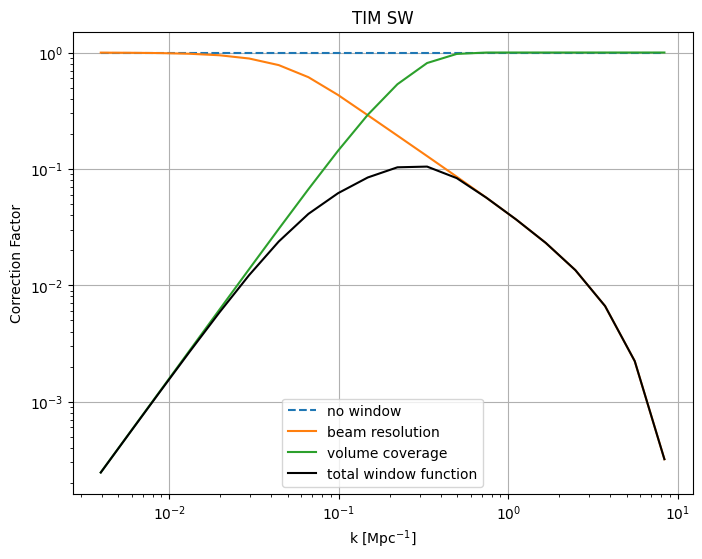

In [162]:
plt.figure(figsize=(8, 6))
plt.plot(kbincenters, ones, label='no window', linestyle='--')
plt.plot(kbincenters, Wres, label='beam resolution')
plt.plot(kbincenters, Wvol, label='volume coverage')
plt.plot(kbincenters, Wres * Wvol, label='total window function', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('Correction Factor')
plt.title('TIM SW')
plt.grid()
plt.legend()